In [1]:
import os
from radar_scenes.sequence import Sequence

# Load RadarScenes dataset.
PATH_TO_DATASET = "/home/robesafe/Datasets/RadarScenes"
if not os.path.exists(PATH_TO_DATASET):
    raise FileNotFoundError("Dataset not found at {}".format(PATH_TO_DATASET))

In [2]:
SEQUENCE_NUMBER = 1
filename = os.path.join(PATH_TO_DATASET, "data", f"sequence_{SEQUENCE_NUMBER}", "scenes.json")
sequence = Sequence.from_json(filename)
SCENES_NUMBER = sum(1 for x in sequence.scenes())  # a dirty way to compute the length of a generator.


In [3]:
# --- GROUP THE SEQUENCES BY 500 MS TIME INTERVAL
timestamps = sequence.timestamps
# print(timestamps)
timestamps_mod = [x - timestamps[0] < 500000 for x in timestamps]
# print(timestamps_mod)

timestamp_in_frame = []
frames = []
pivot = timestamps[0]

for idx, timestamp in enumerate(timestamps):
    if timestamp - pivot > 500000:
        pivot = timestamp
        frames.append(timestamp_in_frame)
        timestamp_in_frame = []
    else:
        timestamp_in_frame.append(timestamp)
    if idx == len(timestamps) - 1:
        frames.append(timestamp_in_frame)

# print(len(frames))
# print(frames)

# chunk = [timestamp for timestamp in timestamps if timestamp - timestamps[0] < 500000]
# print(chunk)

First odom: (156863181607, -172.31, -230.54, -2.6241026, 10.66, 0.00907571)
First x: 4.160003662109375, y: 2.3600006103515625
(156863621606, -176.47, -232.9, -2.6258478, 11.085, -0.00959931)


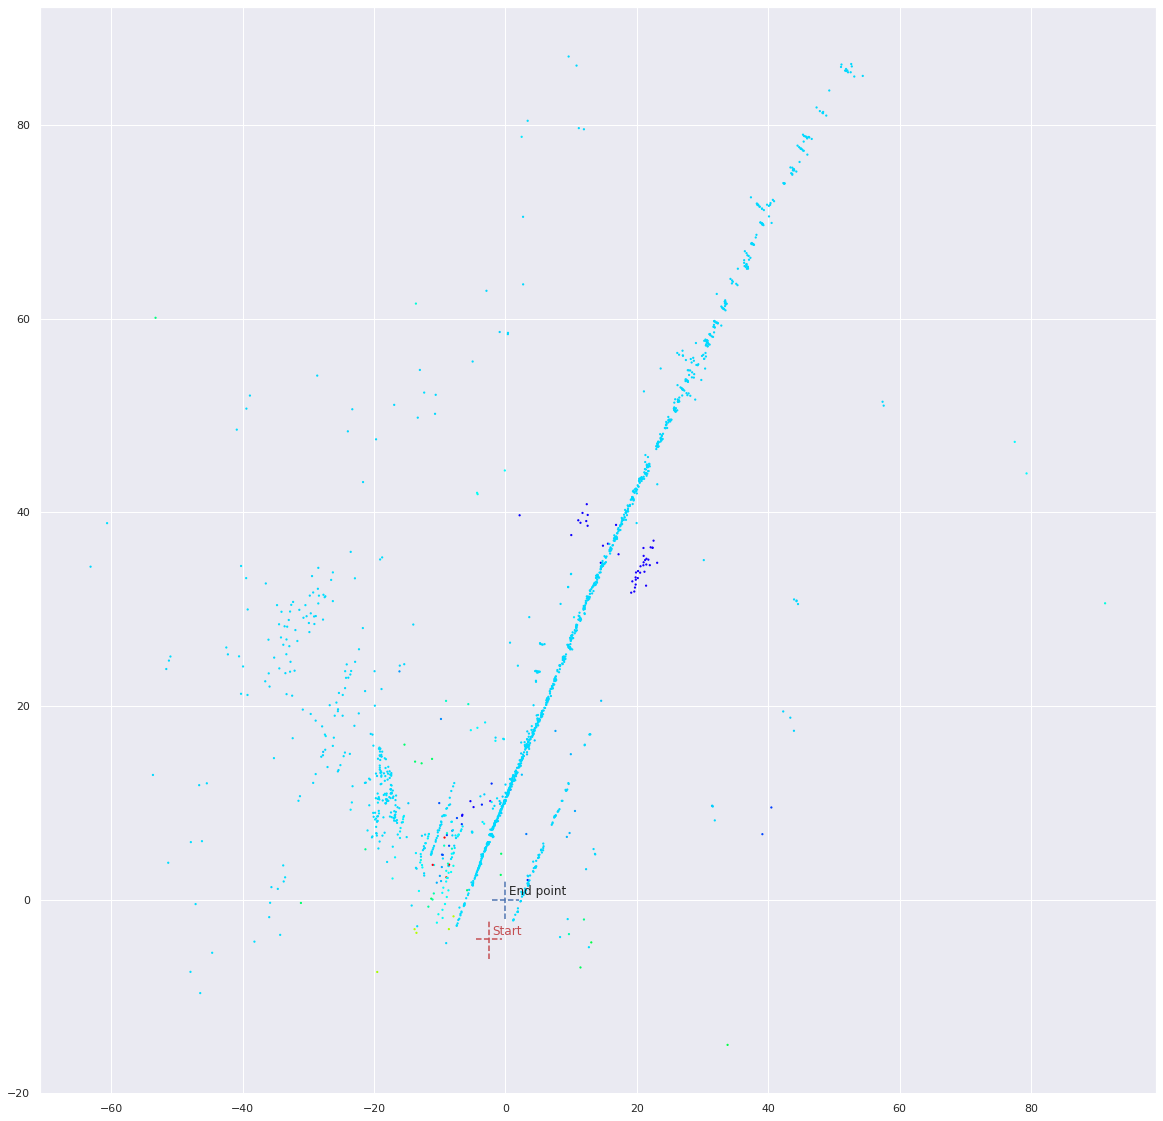

/home/robesafe/Datasets/RadarScenes/data/sequence_1/camera/156863452289.jpg


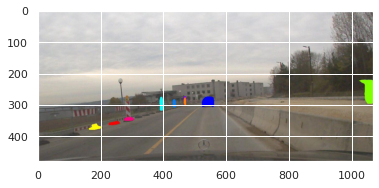

In [4]:
# --- COMBINE POINT CLOUDS IN A FRAME AND CREATE A GRID MAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()

frame = frames[1]
x_array, y_array, c_array = [], [], []
last_scene = sequence.get_scene(frame[-1])
odom = last_scene.odometry_data
camera_image_name = last_scene.camera_image_name
for timestamp in frame:
    scene = sequence.get_scene(timestamp)
    radar_data = pd.DataFrame(scene.radar_data)
    x_array.extend(radar_data["x_seq"].values.tolist())
    y_array.extend(radar_data["y_seq"].values.tolist())
    c_array.extend(radar_data["vr_compensated"].values.tolist())


first_scene = sequence.get_scene(frame[0])
first_odom = first_scene.odometry_data
first_x = first_odom[1] - odom[1]
first_y = first_odom[2] - odom[2]
print(f"First odom: {first_odom}")
print(f"First x: {first_x}, y: {first_y}")

# Translate to car origin
x_array = [x - odom[1] for x in x_array]
y_array = [y - odom[2] for y in y_array]

x_prime, y_prime = [], []

# Rotate yaw_seq at car origin
for (x, y) in zip(x_array, y_array):
    x_prime.append(x*np.cos(odom[3]) - y*np.sin(odom[3]))
    y_prime.append(x*np.sin(odom[3]) + y*np.cos(odom[3]))

first_x_prime = first_x*np.cos(odom[3]) - first_y*np.sin(odom[3])
first_y_prime = first_x*np.sin(odom[3]) + first_y*np.cos(odom[3])


print(odom)
# print(len(x))
# print(radar_data)
plt.figure(figsize=(20, 20))
plt.scatter(x_prime, y_prime, c=c_array, s=1.5, cmap='hsv')

# Start point
plt.vlines(first_x_prime, first_y_prime -2, first_y_prime + 2, linestyles='dashed', colors='r')
plt.hlines(first_y_prime, first_x_prime -2, first_x_prime + 2, linestyles='dashed', colors='r')
plt.text(first_x_prime + 0.5, first_y_prime + 0.5, "Start", color='r')

# End point
plt.vlines(0, -2, 2, linestyles='dashed')
plt.hlines(0, -2, 2, linestyles='dashed')
plt.text(0 + 0.5, 0 + 0.5, "End point")

plt.vlines

plt.show()

# Print image
img = mpimg.imread(camera_image_name)
print(camera_image_name)
imgplot = plt.imshow(img)


0 0


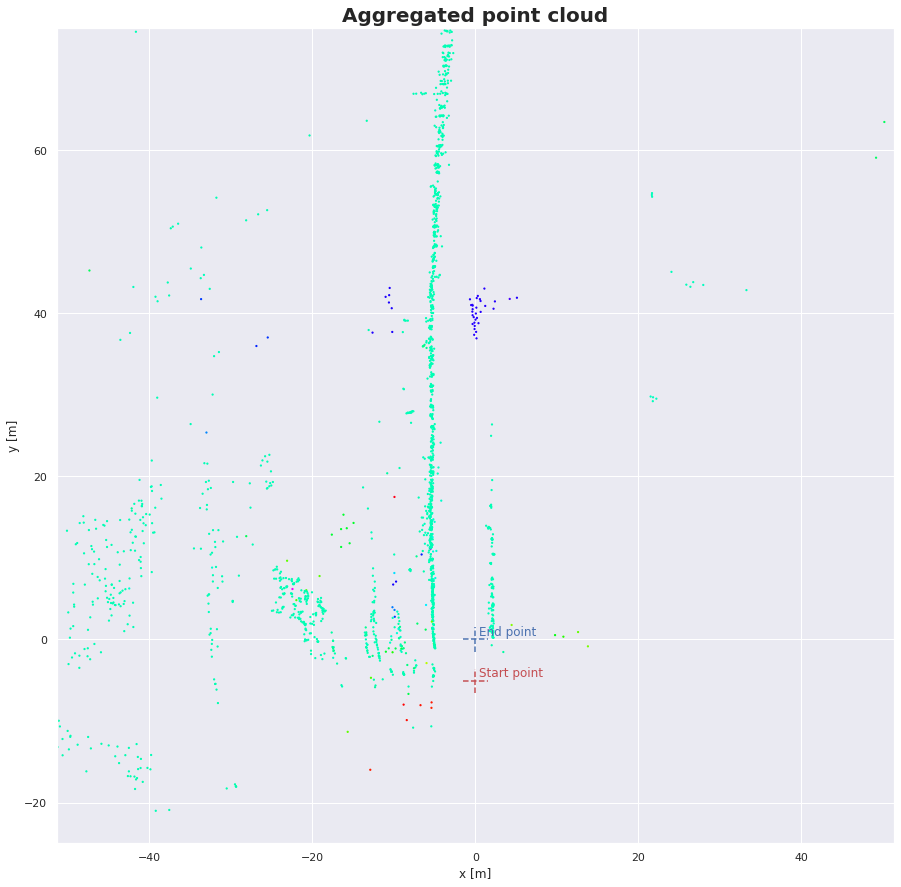

(         timestamp  sensor_id   range_sc  azimuth_sc        rcs        vr  \
 0     156862647501          1   2.566963   -0.124031 -28.300673  0.009330   
 1     156862647501          1   2.096815    0.849328 -26.863953 -8.023678   
 2     156862647501          1   3.338323    1.106456 -26.564907 -9.334642   
 3     156862659751          2   8.882484    1.156905   0.101503 -7.361293   
 4     156862659751          2   9.479269    1.090472  -3.724234 -7.834501   
 ...            ...        ...        ...         ...        ...       ...   
 2115  156863145680          3  19.685274    0.282178 -17.475891 -7.923679   
 2116  156863145680          3  59.212521    0.224860  -0.424088 -8.590881   
 2117  156863145680          3  53.615303    0.352202  -6.697823 -7.291457   
 2118  156863145680          3  54.187893    0.348176  -4.284717 -7.416960   
 2119  156863145680          3  38.747993    0.541255   3.183815 -0.620982   
 
       vr_compensated       x_cc       y_cc       x_seq       

In [6]:
from preprocessing import aggregated_point_cloud, aggregated_camera_image, group_timestamps_by_time, plot_aggregated_point_cloud
test_grouped_timestamps = group_timestamps_by_time(timestamps, 500)
assert test_grouped_timestamps == frames

test_frame = frames[0]
test_image_name = aggregated_camera_image(test_frame, sequence)
test_aggregated_point_cloud = aggregated_point_cloud(test_frame, sequence)
pc = test_aggregated_point_cloud[0]
x0 = test_aggregated_point_cloud[2]
y0 = test_aggregated_point_cloud[3]
x1 = test_aggregated_point_cloud[4]
y1 = test_aggregated_point_cloud[5]

print(x1, y1)
plot_aggregated_point_cloud(pc, x0, y0, x1, y1)
test_aggregated_point_cloud


In [11]:
# --- CREATE A GRID MAP FROM AGGREGATED POINT
N_CELLS = 608
CELL_SIZE = 0.16

# Create and empty 3D grid
grid = np.zeros((N_CELLS, N_CELLS, 4))


# Initialize the third channel at 1000.
grid[:, :, 3] = 1000

# Iterate through each point of the point cloud
for row in pc.iterrows():
    if -50 < row["x_mod"] < 50 and -25 < row["y_mod"] < 75:
        # Get the cell coordinates
        x_cell = int(row["x_mod"] // CELL_SIZE) + N_CELLS // 2
        y_cell = int(row["y_mod"] // CELL_SIZE) + N_CELLS // 4

        # Add the point to the grid
        grid[x_cell, y_cell, 0] = max(row["x_mod"], grid[x_cell, y_cell, 0])
        grid[x_cell, y_cell, 1] = max(row["vr_compensated"], grid[x_cell, y_cell, 1])
        grid[x_cell, y_cell, 2] = min(row["vr_compensated"], grid[x_cell, y_cell, 2])
        grid[x_cell, y_cell, 3] += 1



TypeError: tuple indices must be integers or slices, not str